In [3]:
import warnings

warnings.filterwarnings('ignore')

import os
import random
import numpy as np
import pandas as pd
import scipy.stats as st
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler, OneHotEncoder
from imblearn import over_sampling as osam, under_sampling as usam, combine as cbsam
import sdv
from sdv.sampling import Condition
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer, CTGANSynthesizer, TVAESynthesizer, CopulaGANSynthesizer
import torch

In [4]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything()

In [5]:
df = pd.read_csv('./impute_set/imp3.csv')


In [7]:
df = pd.read_csv('./impute_set/imp3.csv')


def preprocessing(df, num, cat, numeric, category, train=True):
    df_num, df_cat = df[num], df[cat]
    if train:
        df_num = pd.DataFrame(numeric.fit_transform(df_num), columns=df_num.columns)
        df_cat = pd.DataFrame(category.fit_transform(df_cat), columns=df_cat.columns)
    else:
        df_num = pd.DataFrame(numeric.transform(df_num), columns=df_num.columns)
        df_cat = pd.DataFrame(category.transform(df_cat), columns=df_cat.columns)
    res = pd.concat([df_num, df_cat], axis=1)
    return res


def test_with_5fold(df, numeric='minmax', category='label', shuffle=True):
    f1s = []
    X = df.drop('BS3_1', axis=1)
    y = df[['BS3_1']]
    numeric_col = [
        'FEV1', 'FEV1FVC', 'age', 'BS6_3', 'BS6_2_1', 'BD1',
        '건강문해력', 'Total_slp_wk', 'EQ_5D', 'BE3_31', 'BE5_1', '질환유병기간'
    ]
    cat_col = []
    for col in X.columns:
        if col not in numeric_col:
            cat_col.append(col)

    df_num, df_cat = X[numeric_col], X[cat_col]
    if numeric == 'minmax':
        n_pre = MinMaxScaler()
    else:
        n_pre = StandardScaler()
    df_num = pd.DataFrame(n_pre.fit_transform(df_num), columns=df_num.columns)

    if category == 'label':
        c_pre = OrdinalEncoder()
        df_cat = pd.DataFrame(c_pre.fit_transform(df_cat), columns=df_cat.columns)
    else:
        c_pre = OneHotEncoder(sparse_output=False)
        df_cat = pd.DataFrame(c_pre.fit_transform(df_cat))
        # df_cat = df_cat.astype(float)

    X = pd.concat([df_num, df_cat], axis=1)

    if shuffle:
        skf = StratifiedKFold(n_splits=5, shuffle=shuffle, random_state=42)
    else:
        skf = StratifiedKFold(n_splits=5, shuffle=shuffle)
    # X.reset_index().drop('index', axis=1, inplace=True)
    # y.reset_index().drop('index', axis=1, inplace=True)
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        # print(fold+1)
        train_X, train_y = X.iloc[train_idx], y.iloc[train_idx]
        test_X, test_y = X.iloc[test_idx], y.iloc[test_idx]
        pos = train_y.value_counts()[0] / train_y.value_counts()[1]
        # print(pos)

        param = {'n_estimators': 124, 'max_depth': 7, 'learning_rate': 0.003339207651158001, 'gamma': 1.6458936755157638, 'alpha': 4.85704056557763, 'lambda': 2.5184353943919406, 'min_child_weight': 0.3826429176896404, 'max_delta_step': 38, 'subsample': 0.1563403720918737, 'sampling_method': 'uniform', 'tree_method': 'approx', 'grow_policy': 'lossguide', 'max_bin': 339}

        model = XGBClassifier(objective='binary:logistic', device='cuda', random_state=42, scale_pos_weight=pos, **param)    
        model.fit(train_X, train_y, verbose=False, eval_set=[(train_X, train_y),(test_X, test_y)])        
        preds = model.predict(test_X)
        f1_ = f1_score(test_y, preds, average='macro')
        f1s.append(f1_)
    return f1s


def get_cv_results(f1s:list):
    f1s = np.array(f1s)
    mean_f1 = np.mean(f1s)
    std_f1 = np.std(f1s)
    ci95 = st.t.interval(.95, df=len(f1s)-1, loc=mean_f1, scale=std_f1/np.sqrt(len(f1s)))
    return mean_f1, std_f1, ci95


def bootstrap_ci(data, n_boot=1000, ci=95):
    boot_means = []
    for _ in range(n_boot):
        sample = np.random.choice(data, size=len(data), replace=True)
        boot_means.append(np.mean(sample))
    lower = np.percentile(boot_means, (100 - ci) / 2)
    upper = np.percentile(boot_means, 100 - (100 - ci) / 2)
    return np.mean(data), np.std(data), (lower, upper)

In [9]:
# standard normalization | label encoding
f1s = test_with_5fold(df, numeric='standard')
mean_f1, std_f1, ci95 = get_cv_results(f1s)
# print(f1s)
print(f'CV Results: Mean {mean_f1:.2f} | Std {std_f1:.2f} | CI95% {ci95[0]:.2f}~{ci95[1]:.2f}')
_, _, bci95 = bootstrap_ci(f1s)
print(f'Bootstrap CI95% {bci95[0]:.2f}~{bci95[1]:.2f}')

CV Results: Mean 0.74 | Std 0.08 | CI95% 0.65~0.84
Bootstrap CI95% 0.68~0.81


In [10]:
X = df.drop('BS3_1', axis=1)
y = df[['BS3_1']]
numeric_col = [
        'FEV1', 'FEV1FVC', 'age', 'BS6_3', 'BS6_2_1', 'BD1',
        '건강문해력', 'Total_slp_wk', 'EQ_5D', 'BE3_31', 'BE5_1', '질환유병기간'
]
cat_col = []
for col in X.columns:
    if col not in numeric_col:
        cat_col.append(col)

df_num, df_cat = X[numeric_col], X[cat_col]
n_pre = StandardScaler()
df_num = pd.DataFrame(n_pre.fit_transform(df_num), columns=df_num.columns)

c_pre = OrdinalEncoder()
df_cat = pd.DataFrame(c_pre.fit_transform(df_cat), columns=df_cat.columns)

X = pd.concat([df_num, df_cat], axis=1)

from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42, test_size=.2, stratify=y)

pos = train_y.value_counts()[0] / train_y.value_counts()[1]

param = {'n_estimators': 124, 'max_depth': 7, 'learning_rate': 0.003339207651158001, 'gamma': 1.6458936755157638, 'alpha': 4.85704056557763, 'lambda': 2.5184353943919406, 'min_child_weight': 0.3826429176896404, 'max_delta_step': 38, 'subsample': 0.1563403720918737, 'sampling_method': 'uniform', 'tree_method': 'approx', 'grow_policy': 'lossguide', 'max_bin': 339}
model = XGBClassifier(objective='binary:logistic', device='cuda', random_state=42, scale_pos_weight=pos, **param)

model.fit(train_X, train_y)

XGBClassifier(alpha=4.85704056557763, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.6458936755157638, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              lambda=2.5184353943919406, learning_rate=0.003339207651158001,
              max_bin=339, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=38, max_depth=7, max_leaves=None,
              min_child_weight=0.3826429176896404, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=124,
              n_jobs=None, ...)

In [11]:
import shap
explainer = shap.Explainer(model)
shap_values = explainer(test_X)

In [30]:
col_dict={
 # categorical (HE_DM | DE1_dg: 당뇨병 의사진단 여부 --> 당뇨병 유병률(Diabetes prevalence))
 'sex':'Sex', 'occp':'Occupation', 'Edu':'Education level', 'EC1_1':'EEA', '금연지지가족친구여부':'FFSQ', 
 'marri_1':'Marital status', '손자손녀동거여부':'LWG', '건강문해력':'PHS', 'HE_PFThs':'CRH', 'HE_cough1':'CL3M',
 'HE_sput1':'SP3M', '가래양상':'Sputum characteristics', 'BH9_11':'Influenza vaccination', 'DI1_dg':'PDG', 
 'DE1_dg':'Diabetes prevalence', 'DC6_dg':'PDLC', 'BP1':'PSL', 'BP5':'DS2W', 'D_1_1':'Health literacy', 'BS5_1':'PQS-1M', 
 '자기효능감':'Self-efficacy', 'N_DUSUAL':'CUFI', 'BE3_31':'WDW', 'BE5_1':'STDW', 'LQ4_05':'Activity limitation', 
 'BH1_1':'Health check-up', 'BO2_1':'BWCY', 'BO1_1':'BWChY', '질환유병기간':'COPD duration', 'DI1_pt':'Hypertension treatment',
 'DI1_2':'AMU', 'DE1_pt':'Diabetes treatment', 'DE1_3':'DMU', '심한금단증상경험여부':'SWS-E', '전문가의금연권유':'PAQ',
 # numeric
#  'FEV1':'FEV1', 'HE_fev1fvc':'FEV1/FVC', 'age':'Age', 'BS6_3':'Smoking amount',
 'FEV1':'FEV1', 'FEV1FVC':'FEV1/FVC', 'age':'Age', 'BS6_3':'Smoking amount',
 'BS6_2_1':'Smoking duration', 'BD1':'Alcohol consumption', 'Total_slp_wk':'AST', 'EQ_5D':'QoL'
}

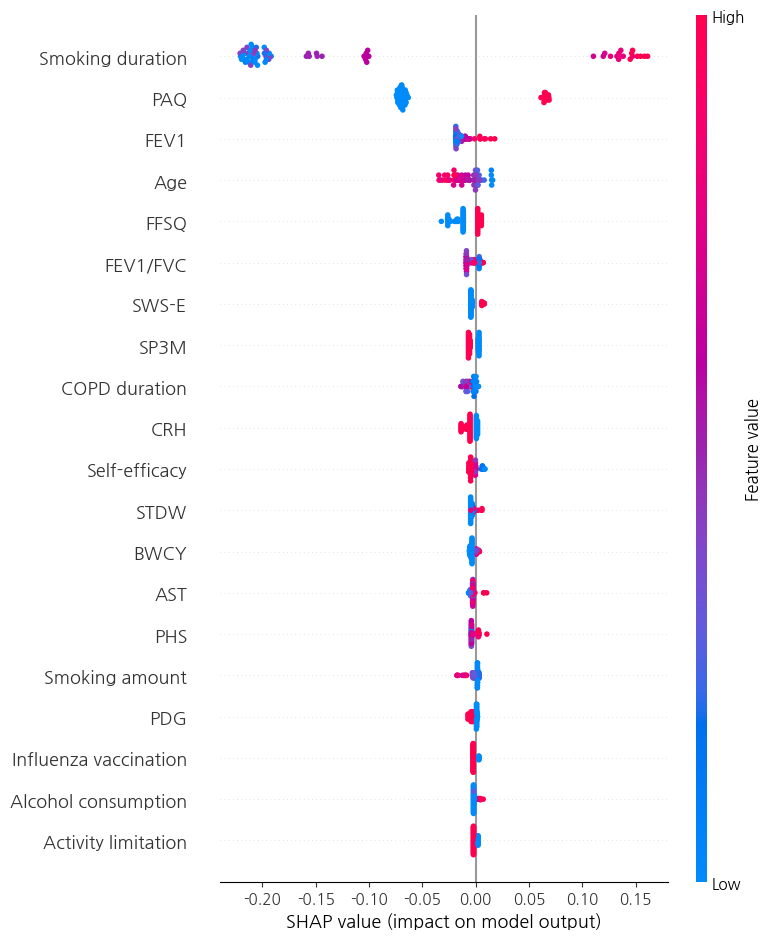

In [35]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

f_names = [col_dict[fcol] for fcol in test_X.columns]
shap.summary_plot(shap_values, test_X, feature_names=[col_dict[fcol] for fcol in test_X.columns])  # Set feature_names if available